# Lab 2: Hebbian Learning


### The Ubiquity of Associations
How do you learn to associate things that occur together?  \\
Peaches and ____________? \\
Cause and ____________? \\
Law and ____________? \\
Sooner or ____________? \\
Jack and ____________ went up ______ ____________ ? \\
 \
You can automatically fill in most or all of the blanks using associations you have learned in the past.  Associations are everywhere in cognition.  You learn to associate all the different properties of individual objects, all the objects that make up familiar scenes, and generally any groups of people, properties and/or things that tend to co-occur.  When you simply look at your laptop you know about its weight, texture, range of likely temperatures, approximately how long the battery will operate before dying, and lots of other associated details.  When you see only the top of a chair on the other side of a solid table you automatically infer details about the rest of the chair that is out of sight --  the top part of the chair that you see is strongly associated with the rest of a representation of a chair.  What do you expect to see in the waiting room of a doctor's office?  As each detail comes to mind it triggers associations to other details: chairs to sit in while you wait --> coffee table --> magazines --> Oprah magazine, Sports illustrated, The Economist --> cheap art on walls --> laminate flooring --> hand sanitizer --> clip boards with forms --> etc.  When you see lightning, what do you expect to hear?  Associations can build up in temporal proximity as well as spatial proximity.  Your stream of consciousness is partly built out of strong and weak associations.  How does the brain learn associations in the first place?  

### A Theory of Learning
Perhaps the most influential early theory in neuroscience is about learning associations, summarized as: "Neurons that fire together, wire together."  The theory was advanced in great detail by Donald Hebb in 1949, who stated, "The general idea is an old one, that any two cells or systems of cells that are repeatedly active at the same time will tend to become 'associated', so that activity in one facilitates activity in the other," and it is now called Hebbian Learning.  It is an elegant theory because it is both simple and has the potential to explain a huge amount of psychological and neuroscientific data.  And it is also a mechanistic theory that we can explore by building models.  

### Unsupervised Learning
Hebbian learning is a type of **unsupervised learning** because it is able to extract structure from data without using feedback.  There are no answers provided in unsupervised learning, only an acquired representation of structure present in the data.  In contrast, **supervised learning** usually involves a decision that can be correct or incorrect (e.g. Is this a picture of a dog or a cat?), and uses training and feedback to improve accuracty.  Subsequent labs will explore supervised learning in detail.     

### In this lab we will cover the following 
### concepts: 
Feature encoding \\
Correlation matrices \\
Simple Hebbian learning \\
Hebbian learning with pruning \\
Necker cubes \\

### tools: 
Matrix multiplication \\
Recurrent transfer mechanisms \\

In [1]:
!pip install psyneulink


Imports Successful
This will be our color palette


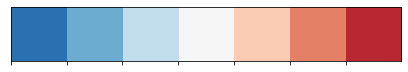

In [2]:
import numpy as np
import matplotlib
from matplotlib import pyplot as plt
%matplotlib inline
import psyneulink as pnl

# This couple of lines sets our color palette
import seaborn as sb
sb.palplot(sb.color_palette("RdBu_r",7))
sb.set_palette("RdBu_r")
sb.set_style("whitegrid")

matplotlib.colors.Colormap("RdBu_r")

print("Imports Successful")
print("This will be our color palette")

## Learning to Group Properties of Objects

Objects typically have multiple properties, such as size, shape, color, texture, density, temperature, etc.  It is useful to learn to group the different properties of an object together.  

In the following cell we begin by defining a set of features.  Our features are size (small, medium, large), color (red, blue, green), and shape (circle, rectangle, triangle).  When one of these features is present, it will be coded as a 1 and when it is absent it will be coded as a 0.  Next we will specify some objects that have subsets of the features.  As you can see in the code below a small red circle is coded as [1,0,0,1,0,0,1,0,0], and then abbreviated to src.

### Stimuli

In [3]:
# define set of features
FeatureNames=['small','medium','large','red','yellow','blue','circle','rectangle','triangle']

# create a variable that corresponds to the size of our feature space
sizeF = len(FeatureNames)  

# define objects composed of features
small_red_circle = [1,0,0,1,0,0,1,0,0]
medium_yellow_rectangle = [0,1,0,0,1,0,0,1,0]
large_blue_triangle = [0,0,1,0,0,1,0,0,1]

# abbreviate the object names
src = small_red_circle
myr = medium_yellow_rectangle
lbt = large_blue_triangle

# Note that feature coding can be more elaborate, e.g. combining the basic feature... 
# e.g. Represent green as the activation of blue+yellow, and use rectangle+triangle for a house
small_green_house = [1,0,0,0,1,1,0,1,1] 
sgh = small_green_house

With our features defined, we can specify a collection of stimuli (sm_3_uniform) that will be presented to the model.  This collection of stimuli is created as a matrix.  Every row in the matrix is one object that will be presented.  Every column in the matrix is a feature (named in FeatureNames). Sm_3_uniform is a stimulus matrix containing three of each of the stimuli.

In [4]:
sm_3_uniform=np.matrix([src,src,src,myr,myr,myr,lbt,lbt,lbt])
sm_3_uniform

matrix([[1, 0, 0, 1, 0, 0, 1, 0, 0],
        [1, 0, 0, 1, 0, 0, 1, 0, 0],
        [1, 0, 0, 1, 0, 0, 1, 0, 0],
        [0, 1, 0, 0, 1, 0, 0, 1, 0],
        [0, 1, 0, 0, 1, 0, 0, 1, 0],
        [0, 1, 0, 0, 1, 0, 0, 1, 0],
        [0, 0, 1, 0, 0, 1, 0, 0, 1],
        [0, 0, 1, 0, 0, 1, 0, 0, 1],
        [0, 0, 1, 0, 0, 1, 0, 0, 1]])

You can also think about every feature as being represented by one artificial neuron.  There is a neuron that fires in response to "small" things and a neuron that fires to "medium" size things, etc: a total of 9 feature neurons.  

When we present a multi-feature stimulus to the system, we expect the relevant neurons to all fire. We want those neurons to become mathematically associated with each other, in roughly the same way that they would become physically associated with each other in the brain.  Later, if only one stimulus (e.g."red") is presented, we will see the associated neurons ("small" and "circle") fire as well.  We want the neurons that fire together to wire together.  

### Hebbian Model #1

To model this, we are going to look at all of the activations to all of the stimuli (conveniently, in this example the stimuli and corresponding patterns of activation are coded the exact same way with 0s and 1s).  Whenever the "red" neuron is active, what other neurons are active?  There is a useful statistic to measure linear relationships between variables; correlation.  Correlation coefficients are bounded between -1 and 1.  There are two important features of a correlation, sign (+/-) and strength.  When two variables always vary together in the same direction (like temperature and the volume of mercury) they are positively correlated.  When two variables vary in opposite directions (like temperature and layers of clothing worn) they are negatively correlated.  When two variables are completely independent, their correlation is 0.  The strength of the relationship is indicated by the magnitude of the absolute value of the correlation coefficient (in terms of strength -1=1; -0.5=0.5).  Look at the stimuli in the figure above.  Red always goes with circle -- these features have a correlation of 1.             

In the next cell we compute a correlation matrix for the features of all of our stimuli.  Rows and columns are the same set of feature neurons, and the values in the matrix are correlations between these neurons.  For example, the value in the first row ("small" neuron) and fifth column ("yellow" neuron) will tell us how often "small" and "yellow" fired at the same time.  (Remember that to inspect this value it is cor_mat_command[0,4] because Python indexing starts with 0 instead of 1.)

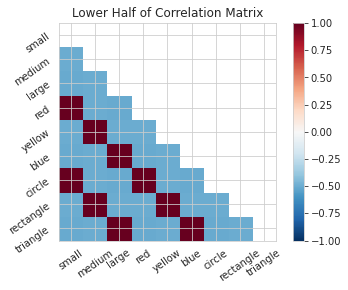

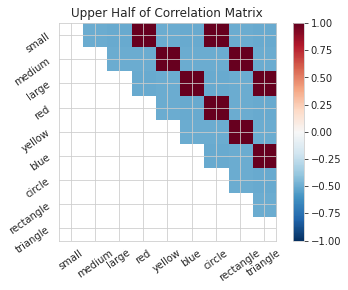

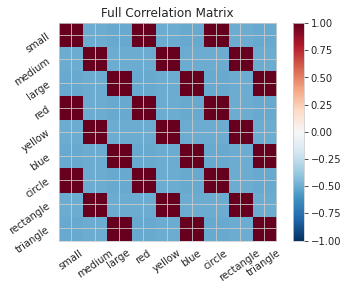

In [5]:
# This portion of the cell creates the correlation matrix
cor_mat_command = np.corrcoef(sm_3_uniform, rowvar=False)
ub=np.amax(np.amax(np.abs(cor_mat_command)))
lb=-ub

# rowvar=False uses columns, rowvar=True uses rows
# It is worth noting that a matrix of correlation coefficients is symmetric across the principal diagonal.

# This portion of the cell visualizes the correlation matrix.
plt.figure()
plt.title('Lower Half of Correlation Matrix')
plt.xticks(np.arange(0,sizeF),FeatureNames,rotation=35)
plt.yticks(np.arange(0,sizeF),FeatureNames,rotation=35)
mask_u =  np.triu(cor_mat_command)
tri_img_u = np.ma.array(cor_mat_command, mask=mask_u)
plt.imshow(tri_img_u,cmap='RdBu_r',vmin=lb,vmax=ub)
plt.colorbar()
plt.show()

plt.figure()
plt.title('Upper Half of Correlation Matrix')
plt.xticks(np.arange(0,sizeF),FeatureNames,rotation=35)
plt.yticks(np.arange(0,sizeF),FeatureNames,rotation=35)
mask_l =  np.tril(cor_mat_command)
tri_img_l = np.ma.array(cor_mat_command, mask=mask_l)
plt.imshow(tri_img_l,cmap='RdBu_r',vmin=lb,vmax=ub)
plt.colorbar()
plt.show()

plt.figure()
plt.title('Full Correlation Matrix')
plt.xticks(np.arange(0,sizeF),FeatureNames,rotation=35)
plt.yticks(np.arange(0,sizeF),FeatureNames,rotation=35)
plt.imshow(cor_mat_command,cmap='RdBu_r',vmin=lb,vmax=ub)
plt.colorbar()
plt.show()


The correlation matrix, cor_mat_command, effectively represents all of the connections between all of our neurons.  The principal diagonal (top left to bottom right) is the self-correlation; a neuron is perfectly correlated with itself, so it should be all 1's.  Except on the diagonal, every connection is depicted twice in this matrix.  For example, [1,2] is the same value as [2,1].  

The correlation matrix can be thought of as the probability that the firing of two neurons will coincide, based on the frequency that their firing coincided in the past. The rows and columns of the matrix represent the features, ordered as they are in our feature list. Each entry represents the connection between a pair of neurons.  One can think of the entries in the correlation matrix as directional probability, where the magnitude gives the strength of association, while the sign gives positive or negative association. 

Positive values mean that the neurons tend to both 1) fire together and 2) be inactive at the same time.  Negative values mean that when one of the neurons is firing, the other one tends to be inactive (and vice a versa).  Values close to 0 mean that the neurons do not exhibit a linear relationship in their patterns of activity.  (Note that correlations only detect linear relationships.  If, for example, the variables had a perfectly U shaped relationship that would produce a correlation of 0.)      

Once the connections between all the feature neurons have been established from learning, these connections can be useful for performing pattern completion.  For example, if the model is given an object that is a triangle, it can use the connections to infer that this object is probably also large and blue.      

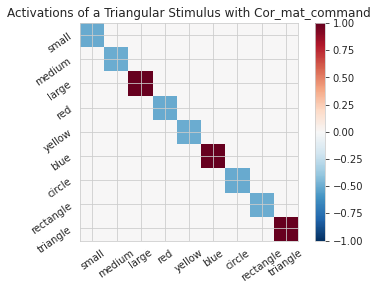

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:27: UserWarning: In Matplotlib 3.3 individual lines on a stem plot will be added as a LineCollection instead of individual lines. This significantly improves the performance of a stem plot. To remove this warning and switch to the new behaviour, set the "use_line_collection" keyword argument to True.


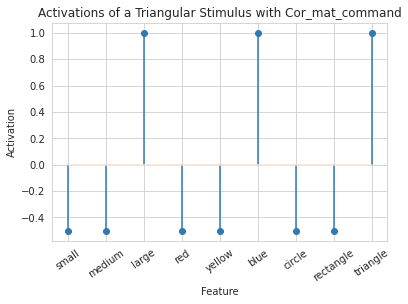

In [6]:
# incomplete stimulus for the trained model, providing only information about shape 
triangle = [0,0,0,0,0,0,0,0,1]

# use the triangle stimulus to activate all neurons connected to the triangle neuron
active_mat = np.dot(np.diag(triangle),cor_mat_command)

# sum the activations 
active_mat.sum(axis=0)

## the previous two steps can be also be accomplished more compactly using 
active_mat=np.matmul(triangle,cor_mat_command)
ub=np.amax(np.amax(np.abs(active_mat)))
lb=-ub

# This plot visualizes the activations from a triangular stimulus. The output is an array,
# and its values are mapped to the principal diagonal of this image. All off-diagonal elements are zero.
plt.figure()
plt.imshow(np.diag(active_mat),cmap='RdBu_r',vmin=lb,vmax=ub)
plt.title('Activations of a Triangular Stimulus with Cor_mat_command')
plt.xticks(np.arange(0,sizeF),FeatureNames,rotation=35)
plt.yticks(np.arange(0,sizeF),FeatureNames,rotation=35)
plt.colorbar()
plt.show()

# This plot shows the same values but as a line plot.
plt.figure()
plt.stem(active_mat)
plt.title('Activations of a Triangular Stimulus with Cor_mat_command')
plt.xticks(np.arange(0,sizeF),FeatureNames,rotation=35)
plt.xlabel('Feature')
plt.ylabel('Activation')
plt.show()



## Exercises

If you have not already done so, create your homework Jupyter notebook now.  This week's lab includes a series of Lab Exercises that you should **complete in lab and include as answers at the beginning of your Homework** file and submission on Blackboard.  You should also try to start and complete as many of the homework questions as you can while still in lab, where you have immediate access to help from your classmates and lab instructor.      

### Accumulating Evidence 

In the previous example we made an over-simplifying assumption that the stimuli were all present at the same time.  But most learning doesn't happen at a single moment in time, it builds up over experience.  We also computed correlations that include negative values, but the most basic implementation of "fire together wire together" should only detect simultaneous firing, not simultaneous absences of firing.  So next we can build a model that accumulates evidence over time and only detects neurons firing together.  

### Hebbian Model #2

We start with an empty connectivity matrix, full of 0's to indicate that no neurons are wired together yet.  When two neurons fire at the same time we'll add a weight of 0.1 to the matrix.

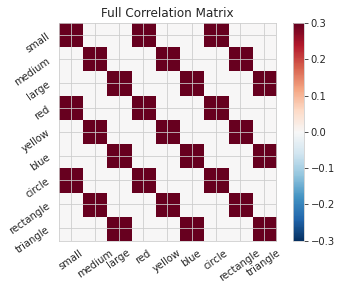

In [7]:
# Create a new, all zeros correlation matrix
cor_mat_manual = np.zeros((sizeF,sizeF)) 

# number of stimuli, np.shape returns the number of rows and columns for an array.  The first value [0] is rows.    
sizeS = np.shape(sm_3_uniform)[0] 

for i in range(sizeS):  # progress through all stimuli
    stim = sm_3_uniform[i]
    for x in range(sizeF): 
        for y in range(sizeF):
            cor_mat_manual[x,y]=cor_mat_manual[x,y]+(stim[0,x]*stim[0,y]*.1)

ub=np.amax(np.amax(np.abs(cor_mat_manual)))
lb=-ub            
           
plt.figure()
plt.title('Full Correlation Matrix')
plt.xticks(np.arange(0,sizeF),FeatureNames,rotation=35)
plt.yticks(np.arange(0,sizeF),FeatureNames,rotation=35)
plt.imshow(cor_mat_manual,cmap='RdBu_r',vmin=lb,vmax=ub)
plt.colorbar()
plt.show()

### Exercise 1

Suppose you want to know what a Hebbian Model #1 learner would associate and infer if they had seen, in their entire experience 10 small red circles, 7 medium yellow rectangles, and 4 large blue triangles --  Then, for the first time, they are exposed to the color purple.  Create a set of stimuli and then a correlation matrix that fit this situation.  How do you code purple as a stimulus?  What output do you get from testing the trained model on an input of purple?  Explain how you interpret this output.

## **Solution**




/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: UserWarning: In Matplotlib 3.3 individual lines on a stem plot will be added as a LineCollection instead of individual lines. This significantly improves the performance of a stem plot. To remove this warning and switch to the new behaviour, set the "use_line_collection" keyword argument to True.
  


Text(0.5, 1.0, 'result on purple stimulus')

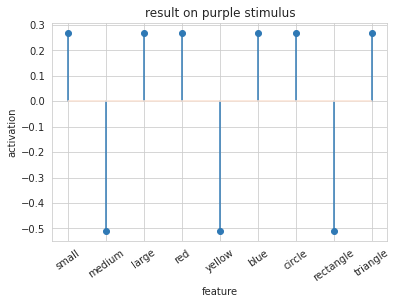

In [8]:
stim_mat=np.matrix([src]*10+[myr]*7+[lbt]*4)
cor_mat= np.corrcoef(stim_mat,rowvar=False)
purple_stim=np.zeros(9)
purple_stim[FeatureNames.index('red')]=.5
purple_stim[FeatureNames.index('blue')]=.5

outp=np.dot(cor_mat,purple_stim)
plt.stem(outp)
plt.xticks(np.arange(0,sizeF),FeatureNames,rotation=35)
plt.ylabel("activation")
plt.xlabel('feature')
plt.title('result on purple stimulus')

We code purple as a stimulus by assuming that the "red" and "blue" features are both halfway active (you could also use 1 instead of .5, without any change to the qualitative results). The resulting pattern generated by the model is likewise a mix between the model's associations of "red" and "blue".   For example, the model associates "purple" with "small" because it has previously learned to associate "red" with "small". Similarly, it associates "purple" with "large" because it has previously learned to associate "blue" with "large". 

## **End Solution**

In the example above, we used 3 loops to update all of the values in cor_mat.  You should reason through how and why this works by considering a few specific examples.  When i = 0, what are the values of stim?  When x and y equal 0, what number will be updated in cor_mat?

There is a more compact way to accomplish the same result as the 3 loops above, using the transpose function and a single loop.    

### Exercise 2a

You can transpose an array (turn rows into columns, and columns into rows) by adding .T to the array:

```{python}
stim_mat[0,:].T
```

And you can do matrix multiplication of two arrays with the appropriate dimensionality using @:

```{python}
stim_mat[0,:].T@stim_mat[0,:] 
```

Now create a single loop that progresses through the stimuli in stim_mat and creates the same resulting cor_mat2 values as above.  


## **Solution**

In [9]:
cor_mat_compact = np.zeros((sizeF,sizeF)) 

# number of stimuli, np.shape returns the number of rows and columns for an array.  The first value [0] is rows.    
sizeS = np.shape(sm_3_uniform)[0] 

for i in range(sizeS):  # progress through all stimuli
  stim=sm_3_uniform[i]
  cor_mat_compact=cor_mat_compact+.1*stim.T@stim

#verify that we got the same answer as before

#allclose returns True if each entry of the first array is equal to the coresponding entry in the second, and False otherwise 
same_ans=np.allclose(cor_mat_compact,cor_mat_manual) 
if same_ans:
  print('cor_mat_compact and cor_mat_manual matrices are equal')

cor_mat_compact and cor_mat_manual matrices are equal


## **End Solution**

### Exercise 2b

Matrix multiplication can simplify the code even more, eliminating the need for any loops.  Use the transpose function .T and matrix multiplication function @ to matrix multiply stim_mat by itself transposed.  As a final step, multiply this entire function by a value that will reproduce the same matrix values in cor_mat above.     

## **Solution**

In [10]:
cor_mat_compactest=np.dot(sm_3_uniform.T,sm_3_uniform)
cor_mat_compactest=cor_mat_compactest* .1 #multiply by the learning rate

#verify correctness
same_ans=np.allclose(cor_mat_compactest,cor_mat_manual) 
if same_ans:
  print('cor_mat_compactest and cor_mat_manual matrices are equal')

cor_mat_compactest and cor_mat_manual matrices are equal


## **End Solution**

In the following cells we are going to progress through a series of steps that unpack some of the functionality in PsyNeuLink Hebbian learning, using Python examples.  Similar to Exercise 1, in the next cell we are going to create a matrix of stimuli that includes 100 small red circles, 70 medium yellow rectangles, and 40 large blue triangles.  Then we will use transpose and matrix multiplication to build a matrix of connection strengths.    

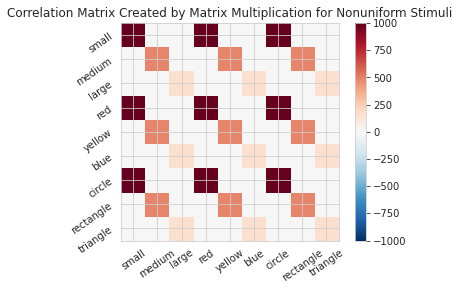

In [11]:
sm_nonuniform=np.array([100*np.array(src),70*np.array(myr),40*np.array(lbt)])
cor_mat_nonuniform=0.1*sm_nonuniform.T@sm_nonuniform

ub=np.amax(np.amax(np.abs(cor_mat_nonuniform)))
lb=-ub
# This portion of the code visualizes the correlation matrix
plt.figure()
plt.imshow(cor_mat_nonuniform,cmap='RdBu_r',vmin=lb,vmax=ub)
plt.title('Correlation Matrix Created by Matrix Multiplication for Nonuniform Stimuli')
plt.xticks(np.arange(0,sizeF),FeatureNames,rotation=35)
plt.yticks(np.arange(0,sizeF),FeatureNames,rotation=35)
plt.colorbar()
plt.show()


Now we can present a purple stimulus to this model, and see what output it generates.    

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: UserWarning: In Matplotlib 3.3 individual lines on a stem plot will be added as a LineCollection instead of individual lines. This significantly improves the performance of a stem plot. To remove this warning and switch to the new behaviour, set the "use_line_collection" keyword argument to True.
  import sys


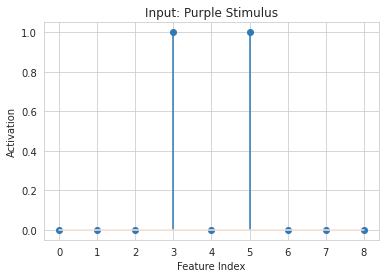

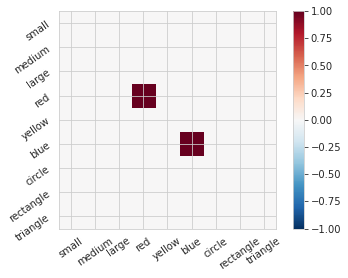

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:37: UserWarning: In Matplotlib 3.3 individual lines on a stem plot will be added as a LineCollection instead of individual lines. This significantly improves the performance of a stem plot. To remove this warning and switch to the new behaviour, set the "use_line_collection" keyword argument to True.


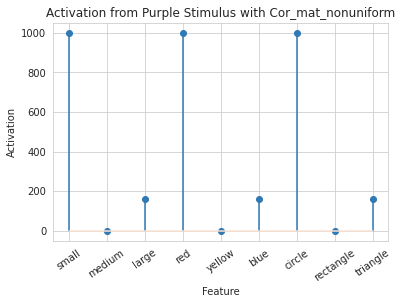

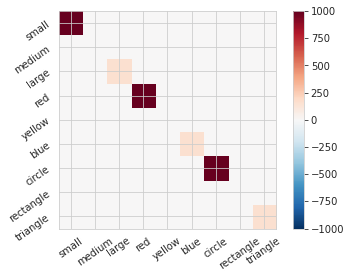

In [12]:
purple=np.array([0,0,0,1,0,1,0,0,0])
purple_act=cor_mat_nonuniform@purple.T

#This section of code visualizes the input: purple

plt.figure()
plt.stem(purple)
plt.title('Input: Purple Stimulus')
plt.xticks(np.arange(0,sizeF))
plt.xlabel('Feature Index')
plt.ylabel('Activation')
plt.show()

# For this image, the vector is mapped to the diagonal of the image and the
# off-diagonal values are set to zero value for visibility

purple_im=np.zeros((sizeF,sizeF))
np.fill_diagonal(purple_im,purple)
ub=np.amax(np.amax(np.abs(purple_im)))
lb=-ub

plt.figure()
plt.imshow(purple_im,cmap='RdBu_r',vmin=lb,vmax=ub)
plt.xticks(np.arange(0,sizeF),FeatureNames,rotation=35)
plt.yticks(np.arange(0,sizeF),FeatureNames,rotation=35)
plt.colorbar()
plt.show()

#This section of code visualizes the output

purple_act_im=np.zeros((sizeF,sizeF))
np.fill_diagonal(purple_act_im,purple_act)
ub=np.amax(np.amax(np.abs(purple_act_im)))
lb=-ub

plt.figure()
plt.stem(purple_act)
plt.title('Activation from Purple Stimulus with Cor_mat_nonuniform')
plt.xticks(np.arange(0,sizeF),FeatureNames,rotation=35)
plt.xlabel('Feature')
plt.ylabel('Activation')
plt.show()

# For this image, the vector is mapped to the diagonal of the image and the
# off-diagonal values are set to zero.

plt.figure()
plt.imshow(purple_act_im,cmap='RdBu_r',vmin=lb,vmax=ub)
plt.xticks(np.arange(0,sizeF),FeatureNames,rotation=35)
plt.yticks(np.arange(0,sizeF),FeatureNames,rotation=35)
plt.colorbar()
plt.show()

# To interpret the output, remember the feature list:
# FeatureNames=['small','medium','large','red','yellow','blue','circle','rectangle','triangle']

The model associated the color purple mostly with small red circle,  slightly with large blue triangle, and not at all with medium yellow rectangle.  This makes sense because the model was trained with more exposure to small red circles.  Purple activated red and it's strongest associates of small and circle.  Purple also activated blue and it's associates of large and triangle.     

### Bounding Output

It is often a good idea to set boundaries on the values of neuron activity in a model.  Most neurons can only physically fire a maximum of a few hundred times per second, and tend to fire closer to the order of around 10 times per second.  Even when we take the liberty of ignoring physical constraints on individual neurons (or even if we assume the unit we are modeling is composed of thousands of neurons and could, in principle, cumulatively send hundreds of thousands of action potentials per second), unbounded values that tend toward +/- infinity cause practical problems for many functions.  In the following cells we will explore some ways to regularize our model outputs.  

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: UserWarning: In Matplotlib 3.3 individual lines on a stem plot will be added as a LineCollection instead of individual lines. This significantly improves the performance of a stem plot. To remove this warning and switch to the new behaviour, set the "use_line_collection" keyword argument to True.
  


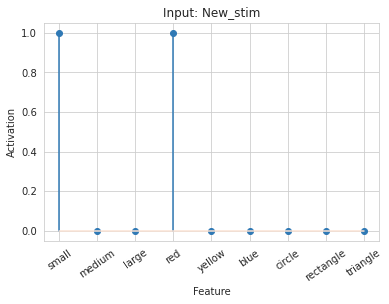

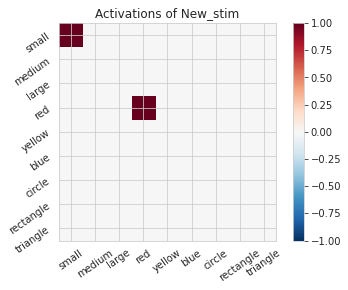

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:39: UserWarning: In Matplotlib 3.3 individual lines on a stem plot will be added as a LineCollection instead of individual lines. This significantly improves the performance of a stem plot. To remove this warning and switch to the new behaviour, set the "use_line_collection" keyword argument to True.


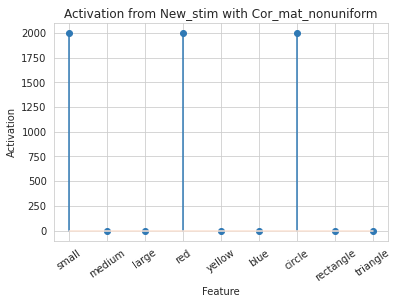

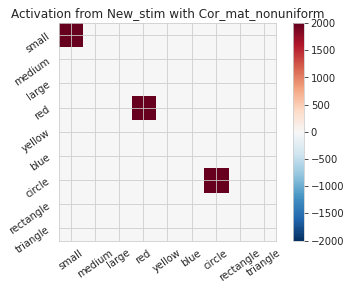

In [13]:
# We define a new stimulus, then transpose it and matrix multiply by cor_mat. 
new_stim=np.array([1,0,0,1,0,0,0,0,0])
new_stim_act=cor_mat_nonuniform@new_stim.T

#This section of code visualizes the input: new_stim

plt.figure()
plt.stem(new_stim)
plt.title('Input: New_stim')
plt.xticks(np.arange(0,sizeF),FeatureNames,rotation=35)
plt.xlabel('Feature')
plt.ylabel('Activation')
plt.show()

# For this image, the vector is mapped to the diagonal of the image and the
# off-diagonal values are set to zero

new_stim_im=np.zeros((sizeF,sizeF))
np.fill_diagonal(new_stim_im,new_stim)
ub=np.amax(np.amax(np.abs(new_stim_im)))
lb=-ub

plt.figure()
plt.imshow(new_stim_im,cmap='RdBu_r',vmin=lb,vmax=ub)
plt.title('Activations of New_stim')
plt.xticks(np.arange(0,sizeF),FeatureNames,rotation=35)
plt.yticks(np.arange(0,sizeF),FeatureNames,rotation=35)
plt.colorbar()
plt.show()

#This section of code visualizes the output

new_stim_act_im=np.zeros((sizeF,sizeF))
np.fill_diagonal(new_stim_act_im,new_stim_act)
ub=np.amax(np.amax(np.abs(new_stim_act)))
lb=-ub

plt.figure()
plt.stem(new_stim_act)
plt.title('Activation from New_stim with Cor_mat_nonuniform')
plt.xticks(np.arange(0,sizeF),FeatureNames,rotation=35)
plt.xlabel('Feature')
plt.ylabel('Activation')
plt.show()

# For this image, the vector is mapped to the diagonal of the image and the
# off-diagonal values are set to zero

plt.figure()
plt.imshow(new_stim_act_im,cmap='RdBu_r',vmin=lb,vmax=ub)
plt.title('Activation from New_stim with Cor_mat_nonuniform')
plt.xticks(np.arange(0,sizeF),FeatureNames,rotation=35)
plt.yticks(np.arange(0,sizeF),FeatureNames,rotation=35)
plt.colorbar()
plt.show()

# To interpret the output, remember the feature list:
# FeatureNames=['small','medium','large','red','yellow','blue','circle','rectangle','triangle']

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: UserWarning: In Matplotlib 3.3 individual lines on a stem plot will be added as a LineCollection instead of individual lines. This significantly improves the performance of a stem plot. To remove this warning and switch to the new behaviour, set the "use_line_collection" keyword argument to True.
  import sys


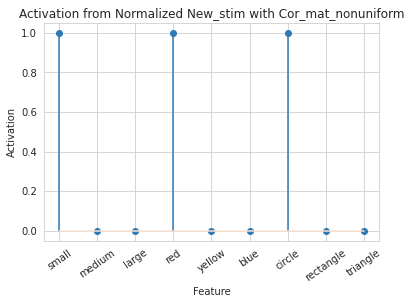

In [14]:
# Dividing an array by its maximum value sets 1 as the maximum value.
new_stim_act=(new_stim_act/max(new_stim_act))

#This section of code visualizes the normalized output

plt.figure()
plt.stem(new_stim_act)
plt.title('Activation from Normalized New_stim with Cor_mat_nonuniform')
plt.xticks(np.arange(0,sizeF),FeatureNames,rotation=35)
plt.xlabel('Feature')
plt.ylabel('Activation')
plt.show()

1000.0


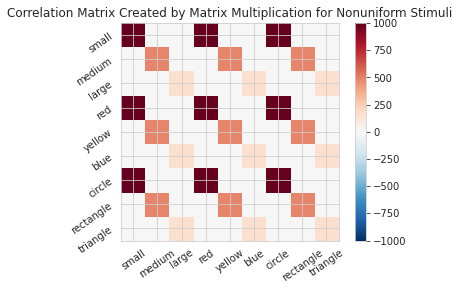

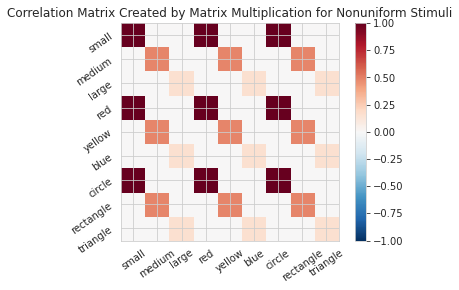

In [15]:
# Initially, this bolsters the values to 1, rather than limiting them. However, with sufficiently repeated stimuli, we know the matrix
# will grow infinitely.

# To find the max value and then regularize the mat itself:

print(np.amax(cor_mat_nonuniform))
ub=np.amax(np.amax(np.abs(cor_mat_nonuniform)))
lb=-ub

# This portion of the code visualizes the correlation matrix
plt.figure()
plt.imshow(cor_mat_nonuniform,cmap='RdBu_r',vmin=lb,vmax=ub)
plt.title('Correlation Matrix Created by Matrix Multiplication for Nonuniform Stimuli')
plt.xticks(np.arange(0,sizeF),FeatureNames,rotation=35)
plt.yticks(np.arange(0,sizeF),FeatureNames,rotation=35)
plt.colorbar()
plt.show()

cor_mat_nonuniform=(np.amax(cor_mat_nonuniform)**-1)*cor_mat_nonuniform
ub=np.amax(np.amax(np.abs(cor_mat_nonuniform)))
lb=-ub

# This portion of the code visualizes the normalized correlation matrix
plt.figure()
plt.imshow(cor_mat_nonuniform,cmap='RdBu_r',vmin=lb,vmax=ub)
plt.title('Correlation Matrix Created by Matrix Multiplication for Nonuniform Stimuli')
plt.xticks(np.arange(0,sizeF),FeatureNames,rotation=35)
plt.yticks(np.arange(0,sizeF),FeatureNames,rotation=35)
plt.colorbar()
plt.show()


# Note how the absolute values change but the relative values are identical

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:14: UserWarning: In Matplotlib 3.3 individual lines on a stem plot will be added as a LineCollection instead of individual lines. This significantly improves the performance of a stem plot. To remove this warning and switch to the new behaviour, set the "use_line_collection" keyword argument to True.
  


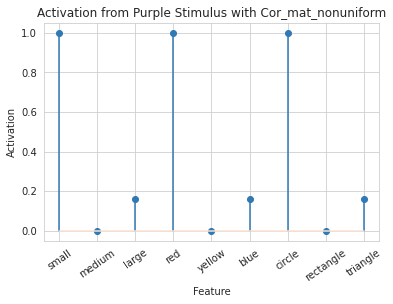

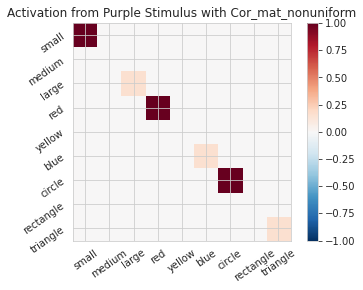

In [16]:
# now, a mixed signal from the purple stimulus produces:
purple=np.array([0,0,0,1,0,1,0,0,0])
purple_act=cor_mat_nonuniform@purple.T

#This section of code visualizes the output

purple_act_im=np.zeros((sizeF,sizeF))
np.fill_diagonal(purple_act_im,purple_act)
ub=np.amax(np.amax(np.abs(purple_act_im)))
lb=-ub


plt.figure()
plt.stem(purple_act)
plt.title('Activation from Purple Stimulus with Cor_mat_nonuniform')
plt.xticks(np.arange(0,sizeF),FeatureNames,rotation=35)
plt.xlabel('Feature')
plt.ylabel('Activation')
plt.show()

# For this image, the vector is mapped to the diagonal of the image and the
# off-diagonal values are set to zero

plt.figure()
plt.imshow(purple_act_im,cmap='RdBu_r',vmin=lb,vmax=ub)
plt.title('Activation from Purple Stimulus with Cor_mat_nonuniform')
plt.xticks(np.arange(0,sizeF),FeatureNames,rotation=35)
plt.yticks(np.arange(0,sizeF),FeatureNames,rotation=35)
plt.colorbar()
plt.show()

# To interpret the output, remember the feature list:
# FeatureNames=['small','medium','large','red','yellow','blue','circle','rectangle','triangle']


### Exercise 3
Consider the code in the following cell.  Your task is to run the cell and reverse engineer what it is accomplishing.  Add comments to each part of the code using # to explain what it is doing.  Then write a few sentences about the entire cell and what useful function it is performing.   

## **Solution**

Solution comments are prefaced with SOLUTION:. Needless to say your comments may look slightly different!

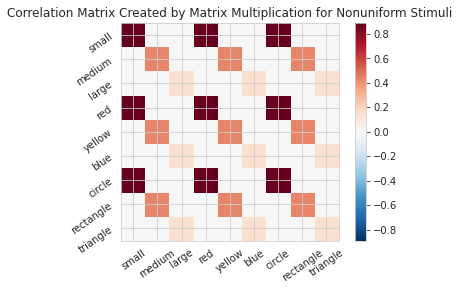

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:40: UserWarning: In Matplotlib 3.3 individual lines on a stem plot will be added as a LineCollection instead of individual lines. This significantly improves the performance of a stem plot. To remove this warning and switch to the new behaviour, set the "use_line_collection" keyword argument to True.


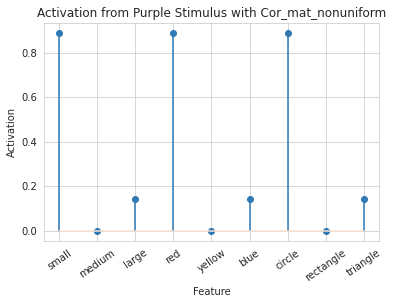

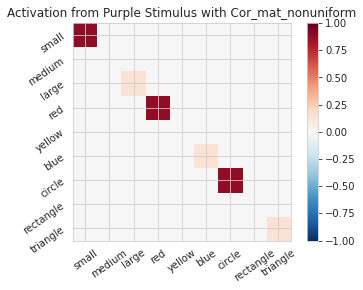

In [17]:


#SOLUTION: define a variable that keeps track of the sum of squares of the diagonal entries
#of the correlation matrix
scalar=0
for i in range (3): #SOLUTION: we sum over the first 3 entries only, because the other diagonal entries will be equal to these
#for example, the entries (small, small) and (red,red) will be equal because "small" and "red" occur the same number of times in the data
    scalar=scalar+cor_mat_nonuniform[i,i]**2

#SOLUTION: we divide by the value of scalar to normalize the scale of the correlations 
#taking the square root ensures that the value has the same units as the original values
scalar=scalar**(-1/2)
cor_mat_nonuniform=scalar*cor_mat_nonuniform
ub=np.amax(np.amax(np.abs(cor_mat_nonuniform)))
lb=-ub

#SOLUTION: the remainder of the code is similar to the previous cell; the only difference is that we are 
#now using the normalized correlation matrix instead


# This portion of the code visualizes the correlation matrix
plt.figure()
plt.imshow(cor_mat_nonuniform,cmap='RdBu_r',vmin=lb,vmax=ub)
plt.title('Correlation Matrix Created by Matrix Multiplication for Nonuniform Stimuli')
plt.xticks(np.arange(0,sizeF),FeatureNames,rotation=35)
plt.yticks(np.arange(0,sizeF),FeatureNames,rotation=35)
plt.colorbar()
plt.show()


purple_act=cor_mat_nonuniform@purple.T
#This section of code visualizes the output

purple_act_im=np.zeros((sizeF,sizeF))
ub=np.amax(np.amax(np.abs(cor_mat_command)))
lb=-ub
np.fill_diagonal(purple_act_im,purple_act)

plt.figure()
plt.stem(purple_act)
plt.title('Activation from Purple Stimulus with Cor_mat_nonuniform')
plt.xticks(np.arange(0,sizeF),FeatureNames,rotation=35)
plt.xlabel('Feature')
plt.ylabel('Activation')
plt.show()

# For this image, the vector is mapped to the diagonal of the image and the
# off-diagonal values are set to zero

plt.figure()
plt.imshow(purple_act_im,cmap='RdBu_r',vmin=lb,vmax=ub)
plt.title('Activation from Purple Stimulus with Cor_mat_nonuniform')
plt.xticks(np.arange(0,sizeF),FeatureNames,rotation=35)
plt.yticks(np.arange(0,sizeF),FeatureNames,rotation=35)
plt.colorbar()
plt.show()


## **End Solution**

## Self-correlation

Up until this point, we have been creating correlation matrices that include self-correlation. That is, a stimulus is positively correlated with itself. This makes sense, because all stimuli correlate with themselves. That is, if we are shown something red, we know we have seen something red. However, if we consider what an output of a Hebbian system should be: the stimuli the learner *associates* with an input (I see red, I think stop sign), this doesn't seem quite right.  After all, if one were prompted to respond to the word "red" with the first word that comes to mind, one would not typically respond, "red".  

From another perspective, a neuron with positive excitatory connections to itself would behave a bit like a microphone placed next to a speaker that is amplifying the input to the microphone -- a runaway positive feedback loop.  In most cases we don't want our models to have seizures.   
  
It follows, that when constructing correlation matrices, it could be useful to remove self-correlation. 

### Exercise 4: Remove self-correlation 
Create a correlation matrix that does not include self-correlation.

## **Solution**

In [18]:
#begin by computing the correlation matrix like before
cor_mat_no_self=0.1*sm_nonuniform.T@sm_nonuniform

for i in range(cor_mat_no_self.shape[0]):
  cor_mat_no_self[i,i]=0

# **End Solution**

## Hebbian Learning In PsyNeuLink

Hebbian learning is achieved in PsyNeuLink by creating an appropriately sized recurrent transfer mechanism, and enabling learning. To do this, when defining your transfer mechanism, we simply set the argument "enable_learning" to True (always include the capital T).

To initialize your matrix to zero, as we have been doing, set the arguments "auto" to 0 and "hetero" to 0.

### Hebbian Model #3

In [19]:
#sample Hebb

Hebb_comp = pnl.Composition()

Hebb_mech=pnl.RecurrentTransferMechanism(
    size=sizeF,
    function=pnl.Linear,
    #integrator_mode = True,
    #integration_rate = 0.5,
    enable_learning = True,
    #learning_rate = 0.5,
    name='Hebb_mech',
    #matrix=pnl.AutoAssociativeProjection,
    auto=0,
    hetero=0
    )

Hebb_comp.add_node(Hebb_mech)


Let's try training our new system on a single stimulus from the set we've been working with; small red circle. 

We can run our system as many times as we like, using only one stimulus as input. In the following cell, we run the system 5 times (num_trials = 5).   

Does the system behave the way you expected it to? In what ways does it behave similar and different to the previous two Hebbian Models #1 & #2?

/usr/local/lib/python3.7/dist-packages/psyneulink/core/compositions/composition.py:7479: UserWarning: Hebb_mech has been specified to project to Hebb_mech recurrent projection, but Hebb_mech recurrent projection is not in Composition-0 or any of its nested Compositions. This projection will be deactivated until Hebb_mech recurrent projection is added to Composition-0 or a composition nested within it.
  f"{node.name} has been specified to project to {receiver.name}, "


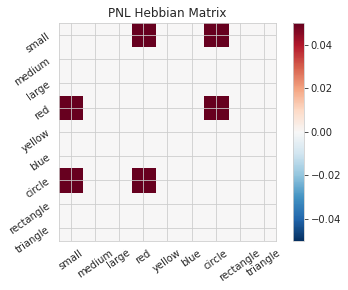

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:23: UserWarning: In Matplotlib 3.3 individual lines on a stem plot will be added as a LineCollection instead of individual lines. This significantly improves the performance of a stem plot. To remove this warning and switch to the new behaviour, set the "use_line_collection" keyword argument to True.


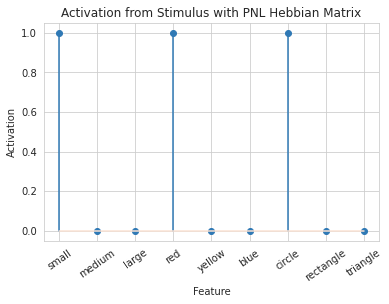

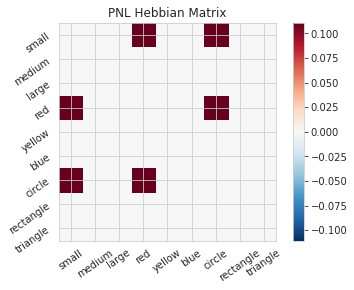

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:23: UserWarning: In Matplotlib 3.3 individual lines on a stem plot will be added as a LineCollection instead of individual lines. This significantly improves the performance of a stem plot. To remove this warning and switch to the new behaviour, set the "use_line_collection" keyword argument to True.


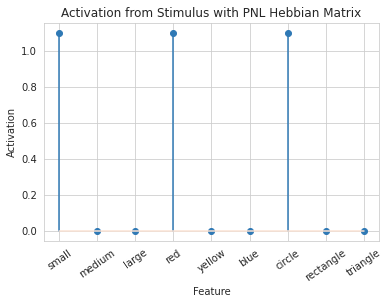

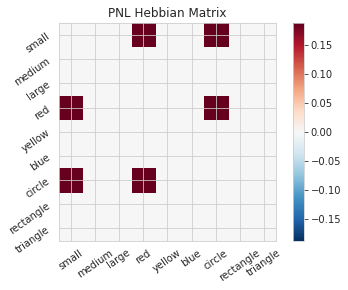

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:23: UserWarning: In Matplotlib 3.3 individual lines on a stem plot will be added as a LineCollection instead of individual lines. This significantly improves the performance of a stem plot. To remove this warning and switch to the new behaviour, set the "use_line_collection" keyword argument to True.


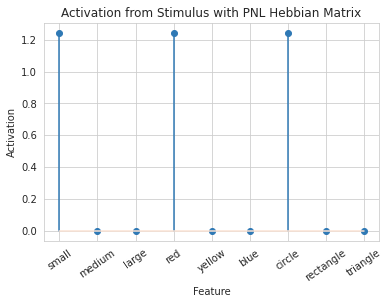

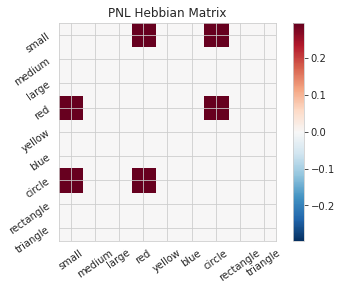

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:23: UserWarning: In Matplotlib 3.3 individual lines on a stem plot will be added as a LineCollection instead of individual lines. This significantly improves the performance of a stem plot. To remove this warning and switch to the new behaviour, set the "use_line_collection" keyword argument to True.


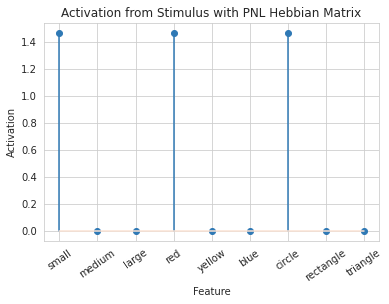

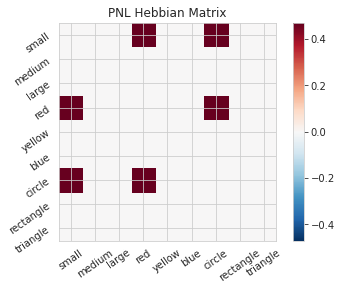

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:23: UserWarning: In Matplotlib 3.3 individual lines on a stem plot will be added as a LineCollection instead of individual lines. This significantly improves the performance of a stem plot. To remove this warning and switch to the new behaviour, set the "use_line_collection" keyword argument to True.


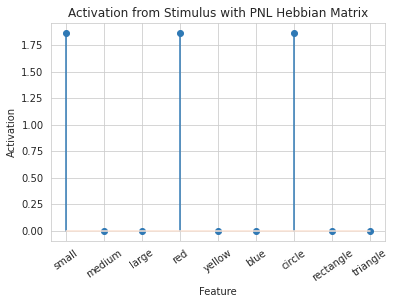

In [20]:
Hebb_comp.execution_id = 1

# Use print_info to show numerical values and vis_info to show graphs of the changing values

def print_info():
    print('\nWeight matrix:\n', Hebb_mech.matrix.base, '\nActivity: ', Hebb_mech.value)

    
def vis_info():
  hebb_matrix = Hebb_mech.matrix.base
  ub=np.amax(np.amax(np.abs(hebb_matrix)))
  lb=-ub
  plt.figure()
  plt.imshow(hebb_matrix,cmap='RdBu_r',vmin=lb,vmax=ub)
  plt.title('PNL Hebbian Matrix')
  plt.xticks(np.arange(0,sizeF),FeatureNames,rotation=35)
  plt.yticks(np.arange(0,sizeF),FeatureNames,rotation=35)

  plt.colorbar()
  plt.show()

  plt.figure()
  plt.stem(Hebb_mech.value[0])
  plt.title('Activation from Stimulus with PNL Hebbian Matrix')
  plt.xticks(np.arange(0,sizeF),FeatureNames,rotation=35)
  plt.xlabel('Feature')
  plt.ylabel('Activation')
  plt.show()

inputs_dict = {Hebb_mech:src}
out=Hebb_comp.learn(num_trials=5,
      call_after_trial=vis_info,
      inputs=inputs_dict)

To better understand what is happening, try running your system once with your chosen input (e.g. src), and then several more times with no input (all 0's).  To do this you will need to re-initialize the system by rerunning the cell that created Hebbian Model #3, or by copying that code into the top of the next cell.  Models that learn get modified by running, and so we need to re-initialize to see how the model evolves with different kinds of input.    

# Exercise 5:

Write an explanation of what is happening, mathematically and qualitatively in the PNL Hebbian algorithm. If your understanding is correct, you will understand what occurs in the next section

## **Solution**


From a qualitative perspective, we can think of the PNL Hebbian algorithm as increasing the weight between any two pairs of features whenever it encounters a simulus that contains that particular combination of features. For example, a small red circle would cause it to increase the weight between "small" and "red", but not between "small" and "blue". Unlike both of our earlier Hebbian models,however, this algorithm does not include self-correlations. This can be seen from the diagonal entries of the weight matrices being zero. Also, unlike the Hebbian model #1, the entires in the weight matrices for the PNL Hebbian algorithm are never negative. 

Mathematically speaking, the algorithm updates the weight $w_{ij}$ between feature i and feature j according to the equation $\Delta w_{ij}=\alpha x_i x_j$, where $\alpha$ denotes the learning rate and $x_i$ and $x_j$ denote the values of the $i$th and $j$th features on the input vector $x$. Here we assume that the features $i$ and $j$ are different from each other; if $i=j$ then the Hebbian network does not update the weight. This description is also corroborated by the [Psyneulink Documentation](https://princetonuniversity.github.io/PsyNeuLink/RecurrentTransferMechanism.html#recurrenttransfermechanism-overview) 

## **End Solution**

# Orthogonal stimuli in PNL:

Now, we are going to train our system on two unrelated stimuli, src and myr. Use your previous code to train the system 5 times on src and 5 times on myr. 

Does the system behave as expected?

If we wanted to produce results similar to our earlier Hebbian models, how would we do so? Alter the code so that it behaves that way. (Hint: Look for a relation between the weight matrix and the previous _output_ of the network. How could you force the output to be zero?)

## **Solution**

/usr/local/lib/python3.7/dist-packages/psyneulink/core/compositions/composition.py:7479: UserWarning: Hebb_mech-1 has been specified to project to Hebb_mech-1 recurrent projection, but Hebb_mech-1 recurrent projection is not in Composition-1 or any of its nested Compositions. This projection will be deactivated until Hebb_mech-1 recurrent projection is added to Composition-1 or a composition nested within it.
  f"{node.name} has been specified to project to {receiver.name}, "


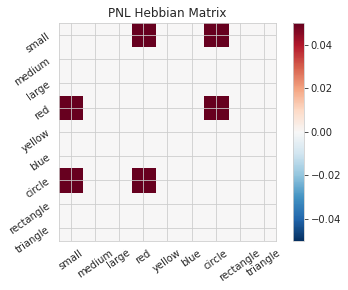

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:23: UserWarning: In Matplotlib 3.3 individual lines on a stem plot will be added as a LineCollection instead of individual lines. This significantly improves the performance of a stem plot. To remove this warning and switch to the new behaviour, set the "use_line_collection" keyword argument to True.


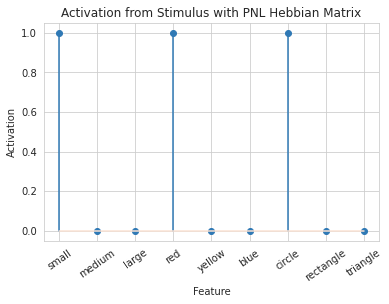

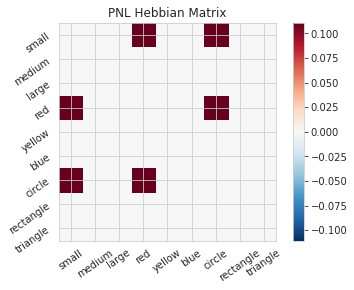

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:23: UserWarning: In Matplotlib 3.3 individual lines on a stem plot will be added as a LineCollection instead of individual lines. This significantly improves the performance of a stem plot. To remove this warning and switch to the new behaviour, set the "use_line_collection" keyword argument to True.


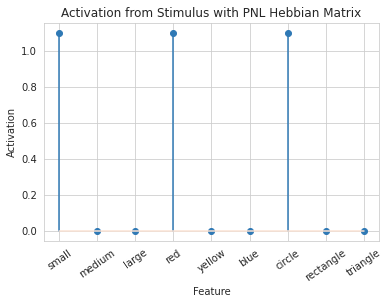

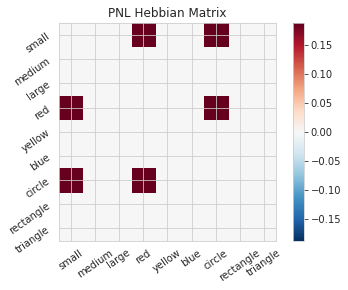

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:23: UserWarning: In Matplotlib 3.3 individual lines on a stem plot will be added as a LineCollection instead of individual lines. This significantly improves the performance of a stem plot. To remove this warning and switch to the new behaviour, set the "use_line_collection" keyword argument to True.


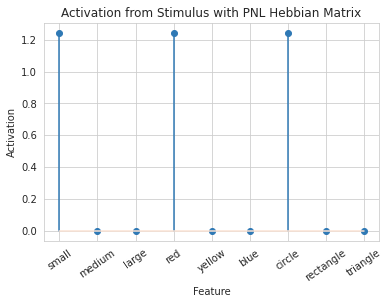

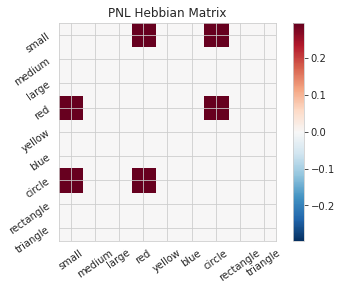

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:23: UserWarning: In Matplotlib 3.3 individual lines on a stem plot will be added as a LineCollection instead of individual lines. This significantly improves the performance of a stem plot. To remove this warning and switch to the new behaviour, set the "use_line_collection" keyword argument to True.


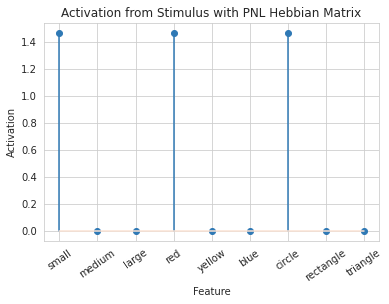

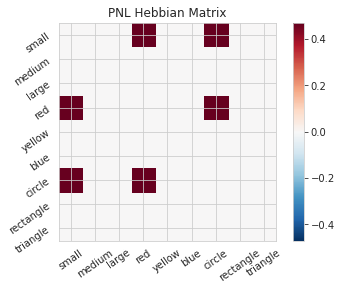

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:23: UserWarning: In Matplotlib 3.3 individual lines on a stem plot will be added as a LineCollection instead of individual lines. This significantly improves the performance of a stem plot. To remove this warning and switch to the new behaviour, set the "use_line_collection" keyword argument to True.


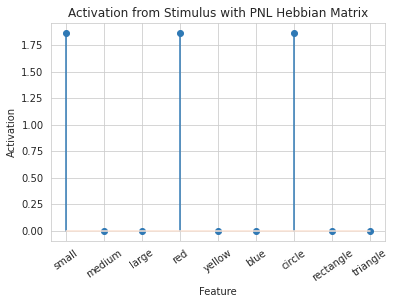

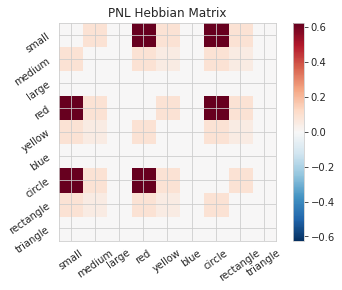

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:23: UserWarning: In Matplotlib 3.3 individual lines on a stem plot will be added as a LineCollection instead of individual lines. This significantly improves the performance of a stem plot. To remove this warning and switch to the new behaviour, set the "use_line_collection" keyword argument to True.


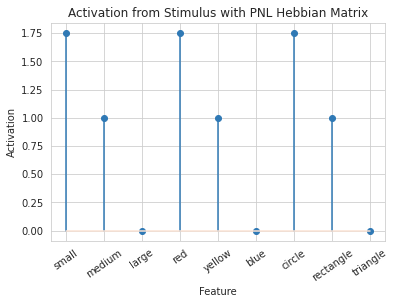

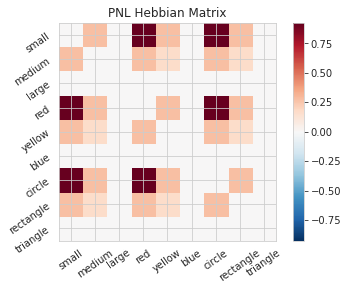

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:23: UserWarning: In Matplotlib 3.3 individual lines on a stem plot will be added as a LineCollection instead of individual lines. This significantly improves the performance of a stem plot. To remove this warning and switch to the new behaviour, set the "use_line_collection" keyword argument to True.


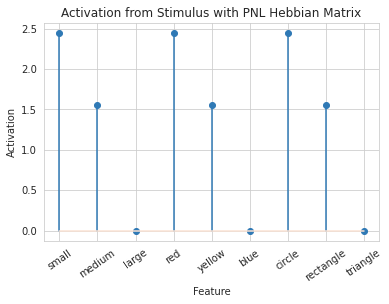

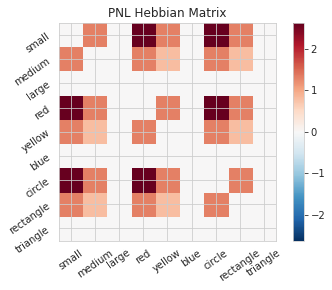

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:23: UserWarning: In Matplotlib 3.3 individual lines on a stem plot will be added as a LineCollection instead of individual lines. This significantly improves the performance of a stem plot. To remove this warning and switch to the new behaviour, set the "use_line_collection" keyword argument to True.


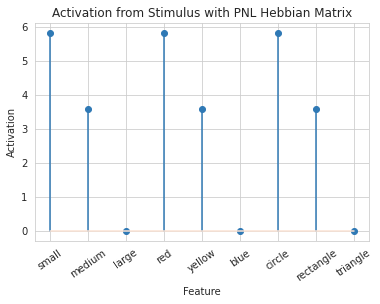

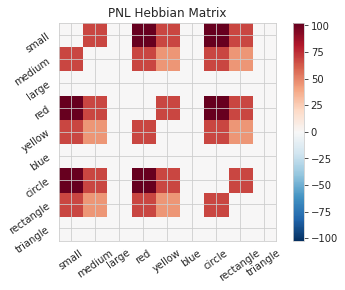

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:23: UserWarning: In Matplotlib 3.3 individual lines on a stem plot will be added as a LineCollection instead of individual lines. This significantly improves the performance of a stem plot. To remove this warning and switch to the new behaviour, set the "use_line_collection" keyword argument to True.


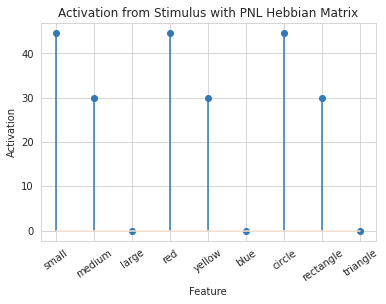

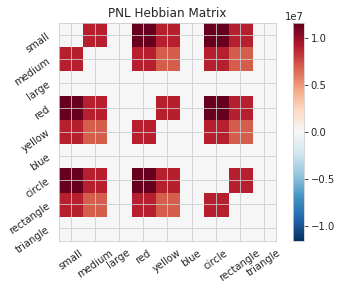

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:23: UserWarning: In Matplotlib 3.3 individual lines on a stem plot will be added as a LineCollection instead of individual lines. This significantly improves the performance of a stem plot. To remove this warning and switch to the new behaviour, set the "use_line_collection" keyword argument to True.


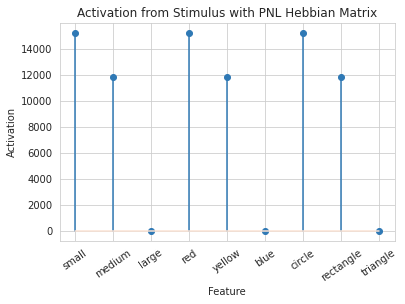

In [21]:
#redefine the model so that it is not influenced by the previous inputs


Hebb_comp = pnl.Composition()

Hebb_mech=pnl.RecurrentTransferMechanism(
    size=sizeF,
    function=pnl.Linear,
    #integrator_mode = False,
    #integration_rate = .5,
    enable_learning = True,
    #learning_rate = 0.5,
    name='Hebb_mech',
    #matrix=pnl.AutoAssociativeProjection,
    auto=0,
    hetero=0
    )

Hebb_comp.add_node(Hebb_mech)
inputs_dict = {Hebb_mech:[src]*5+[myr]*5}
out=Hebb_comp.learn(num_trials=10,
      call_after_trial=vis_info,
      inputs=inputs_dict)

During the first five trials, the algorithms behaves very similarly to the Hebbian Model #2 we defined above (except with the diagonal entries being set to zero). However, after introducing the second stimulus on the fifth trial, the model appears to learn several extra associations that were not learned by our previous model. It appears that the model is learning assocations *between* different stimulus patterns, rather than just *within* a single pattern, as the previous models did. For example, it learns associations "small-medium", "small-yellow" and "small-rectangle", representing a mixture of the features from the small red circle with those of the medium yellow rectangle. In order to suppress this behavior and bring the model more in line with our previous Hebbian models, we can pass the model a null input consisting of all zeros as illustrated below: 

/usr/local/lib/python3.7/dist-packages/psyneulink/core/compositions/composition.py:7479: UserWarning: Hebb_mech-2 has been specified to project to Hebb_mech-2 recurrent projection, but Hebb_mech-2 recurrent projection is not in Composition-2 or any of its nested Compositions. This projection will be deactivated until Hebb_mech-2 recurrent projection is added to Composition-2 or a composition nested within it.
  f"{node.name} has been specified to project to {receiver.name}, "


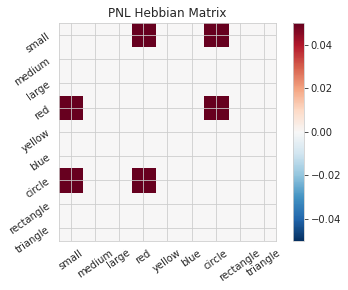

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:23: UserWarning: In Matplotlib 3.3 individual lines on a stem plot will be added as a LineCollection instead of individual lines. This significantly improves the performance of a stem plot. To remove this warning and switch to the new behaviour, set the "use_line_collection" keyword argument to True.


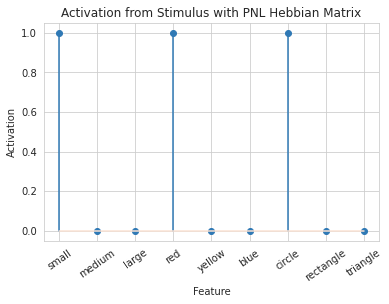

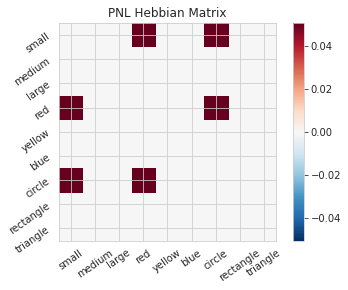

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:23: UserWarning: In Matplotlib 3.3 individual lines on a stem plot will be added as a LineCollection instead of individual lines. This significantly improves the performance of a stem plot. To remove this warning and switch to the new behaviour, set the "use_line_collection" keyword argument to True.


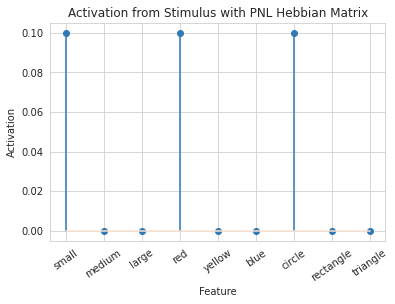

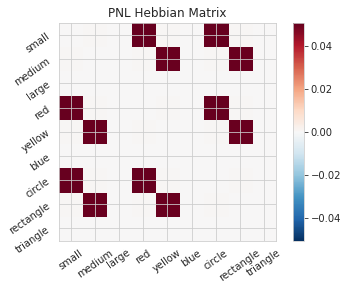

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:23: UserWarning: In Matplotlib 3.3 individual lines on a stem plot will be added as a LineCollection instead of individual lines. This significantly improves the performance of a stem plot. To remove this warning and switch to the new behaviour, set the "use_line_collection" keyword argument to True.


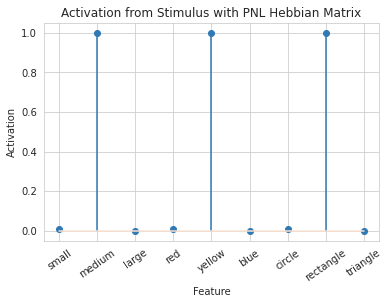

In [22]:
Hebb_comp = pnl.Composition()

Hebb_mech=pnl.RecurrentTransferMechanism(
    size=sizeF,
    function=pnl.Linear,
    #integrator_mode = False,
    #integration_rate = .5,
    enable_learning = True,
    #learning_rate = 0.5,
    name='Hebb_mech',
    #matrix=pnl.AutoAssociativeProjection,
    auto=0,
    hetero=0
    )
Hebb_comp.add_node(Hebb_mech)


inputs_dict = {Hebb_mech:[src,np.zeros(9),myr]}
out=Hebb_comp.learn(num_trials=3,
      call_after_trial=vis_info,
      inputs=inputs_dict)



A less "hacky" way to accomplish the same thing is to define a function that clears the output of the network after each trial. This can be done by defining a suitable function to clear the value, and to call it after every trial in a similar fashion to how we called the vis_info function after each trial. 

/usr/local/lib/python3.7/dist-packages/psyneulink/core/compositions/composition.py:7479: UserWarning: Hebb_mech-3 has been specified to project to Hebb_mech-3 recurrent projection, but Hebb_mech-3 recurrent projection is not in Composition-3 or any of its nested Compositions. This projection will be deactivated until Hebb_mech-3 recurrent projection is added to Composition-3 or a composition nested within it.
  f"{node.name} has been specified to project to {receiver.name}, "


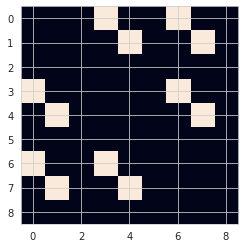

In [23]:
def clear_value():
  Hebb_mech.value[0]=0

Hebb_comp = pnl.Composition()

Hebb_mech=pnl.RecurrentTransferMechanism(
    size=sizeF,
    function=pnl.Linear,
    #integrator_mode = False,
    #integration_rate = .5,
    enable_learning = True,
    #learning_rate = 0.5,
    name='Hebb_mech',
    #matrix=pnl.AutoAssociativeProjection,
    auto=0,
    hetero=0
    )
Hebb_comp.add_node(Hebb_mech)


inputs_dict = {Hebb_mech:[src]*5+[myr]*5}
out=Hebb_comp.learn(num_trials=10,
      call_after_trial=clear_value,
      inputs=inputs_dict)

plt.imshow(Hebb_mech.matrix.base)

## **End Solution**

##Note: The Bonus Questions are somewhat open-ended and there are multiple reasonable solutions, so your solutions may look different from these. 

# Bonus Exercises

Refer to the homework formatting and submission instructions from Lab 1.   Also, for Lab 2 be sure to include your answers to the other exercises from throughout the lab.


## Exercise 6: Stump the Hebbian Learning Algorithm
Create a set of at least 9 unique stimuli using the same 9 feautres as above with properties that are impossible for the Hebbian Model #1 to learn and use for accurate inferences.  Even after exposure to the stimuli, the correlation matrix should be full of 0s.  Explain why these results are produced.  Try to come up with an interesting example that might map on to a real world situation (rather than just a mathematical gimic).  

## **Solution**

We can create a set of stimuli with uncorrelated features by taking all possible combinations of feature values. We will first verify that the idea works using a smaller example with only 3 features.


correlation matrix=
[[0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]]


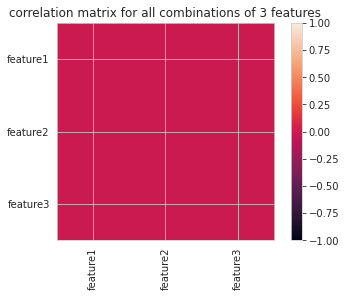

In [24]:
all_combs_3x3=np.array([[0,0,0],[1,0,0],
               [0,1,0],[1,1,0],
               [0,0,1],[1,0,1],
               [0,1,1],[1,1,1]])

rand_stims_cor=np.corrcoef(all_combs_3x3.T)
for i in range(3):
  rand_stims_cor[i,i]=0
print('correlation matrix=')
print(rand_stims_cor)
plt.title('correlation matrix for all combinations of 3 features')
plt.imshow(rand_stims_cor,vmin=-1,vmax=1)
plt.yticks(np.arange(3),['feature1','feature2','feature3'])
plt.xticks(np.arange(3),['feature1','feature2','feature3'],rotation=90)

plt.colorbar()


We do indeed get a correlation matrix of all zeros, so we could try to do the same thing for the length 9 feature vectors we have been using. But there are two additional issues:


1.   We had to use all combinations of features. For 3 features this was only $2^3=8$, but for 9 features we will need $2^9=512$.
2.   Some of the features that we have been using are mutually exclusive. For example, it does not make sense to have an object that is both large and small. So even if we could write out all of the combinations, not all of them will be meaningful. 

We get circumvent both of these issues by using random sampling. This way we won't have to explicitly write out all of the combinations, but because of the Law of Large Numbers, we'll end up with a result that is very close to what it would be if we had written them all out. Also when we do the sampling, we can make sure that we never sample inconsistent combinations like "small" and "big". 

 







correlation matrix=
[[ 0.         -0.45425676 -0.58730159 -0.08228454 -0.03604666 -0.10323461
   0.02373555  0.14926172 -0.16065966]
 [-0.45425676  0.         -0.45425676  0.04391298 -0.01185735  0.04249586
   0.09562992  0.07335372 -0.15822342]
 [-0.58730159 -0.45425676  0.          0.04238901  0.04681922  0.06462655
  -0.11061663 -0.21590457  0.30440777]
 [-0.08228454  0.04391298  0.04238901  0.          0.0585995   0.02764359
   0.01127956 -0.02918367  0.01638244]
 [-0.03604666 -0.01185735  0.04681922  0.0585995   0.          0.01702266
   0.05147051 -0.12299654  0.06533279]
 [-0.10323461  0.04249586  0.06462655  0.02764359  0.01702266  0.
   0.00087617 -0.03661399  0.03308611]
 [ 0.02373555  0.09562992 -0.11061663  0.01127956  0.05147051  0.00087617
   0.         -0.42837698 -0.54728138]
 [ 0.14926172  0.07335372 -0.21590457 -0.02918367 -0.12299654 -0.03661399
  -0.42837698  0.         -0.52182417]
 [-0.16065966 -0.15822342  0.30440777  0.01638244  0.06533279  0.03308611
  -0.54728

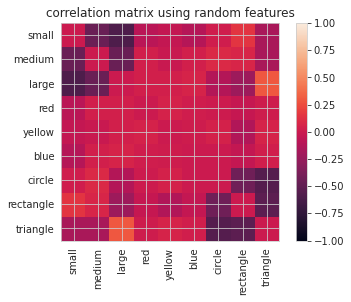

In [25]:
sampled_features=[]
for _ in range(100):
  feats=np.zeros(9)
  #first we sample a size (small,medium,large)
  size_feat=np.random.choice(3)
  feats[size_feat]=1
  #unlike sizes and shapes, colors are not mutually exclusive, so we can sample them independently
  for c in range(3):
    feats[3+c]=np.random.choice(2)

  #sample a shape
  shape_feat=np.random.choice(3)
  feats[6+shape_feat]=1
  sampled_features.append(feats)
sampled_features=np.array(sampled_features)
sampled_features_cor=np.corrcoef(sampled_features.T)
for i in range(9):
  sampled_features_cor[i,i]=0
plt.title('correlation matrix using random features')
plt.imshow(sampled_features_cor,vmin=-1,vmax=1)
plt.xticks(np.arange(9),FeatureNames,rotation=90)
plt.yticks(np.arange(9),FeatureNames)
plt.colorbar()
print('correlation matrix=')
print(sampled_features_cor)

We can see from the correlation matrix that the most of the entries are very close to 0. The exception is when either both features are a size, or both are a shape. For example, the (small,large) entry is a large negative value, but this is unavoidable because these features are mutually exclusive, meaning that the presence of one of these will always predict the absence of the other. If we showed the Hebbian network a small network, it would not be able to predict any other features of the object (except that it is not medium-sized and not large). 

A real world analogue of this example would be a deck of playing cards. We can represent a playing card using 17 binary features, with the first 13 corresponding to the value of the card and the last 4 corresponding to the suit.  If draw a card and tell you that it is an Ace, then that gives you no information about its suit. However, it does let you deduce that it is not a King.   

## **End Solution**

## Exercise 7: Pruning Instead of Connecting

Build a new model based on Hebbian Model #2 that starts with every unit connected to every other neuron, all with equal positive weights (all 1s).  As this model receives stimuli it should preserve the connections between neurons that fire together, and gradually weaken the connections between neurons that do not fire together.  

A prominent feature of brain development from infancy to adulthood is the reduction of neurons and increase in glial cells (Burek & Openheim, 1996; Low & Cheng, 2006).  For example, one study inspecting a brain area for comparison between newborns and adults found that the adult brains had about 40% fewer neurons and 340% more glials cells (Abitz et al, 2007).  Weakening and elimination of connections is often called pruning, and might be more common than growing entirely new connections.  Imagine that a neuron somewhere near your forehead is firing correlated with a neuron somewhere near the back of your head -- it would be difficult to grow an entirely new axon that connects the two.  Instead, during early development when the brain begins by occupying a tiny volume, it is easy to start with many neurons connected and preserve these connections as the brain grows larger.  Later, neurons that are connected and fire together can strengthen their connections, while neurons that fire independently can weaken their connections or let the connections be pruned away entirely. 

Train this model on stim_mat and test it to make inferences on at least three different single-feature stimuli, such as triangle = [0,0,0,0,0,0,0,0,1].  How does it perform?  

Discuss the various choices that you made when creating this model.  For example, do you allow the connection weights between neurons to ever go below 0?  Why or why not?  What rate of pruning did you decide to implement, and why did you choose this number?  How might you reasonably adjust the pruning rate to depend on the total number of expected stimuli (would you use the same rate for 3 stimuli and 3000 stimuli)?   

## **Solution**

To do the pruning, we will weaken the connection between two neurons whenever they don't fire together. More precisely, given two features $x_i,x_j$, we will do nothing to the weight $w_{ij}$ if $x_ix_j>0$. But if $x_ix_j=0$ then we will change the weight according to the learning rule

$$\Delta w_{ij}=(1-\gamma) w_{ij}$$

Here $\gamma$ is a number between 0 and 1 that controls the speed of the pruning. 

Because we initialize the weights to be equal to 1, our definition of the pruning learning rule implies that they will never go below zero. This makes sense biologically, because a neuron cannot have a negative firing rate. 

After experimenting with several pruning factors, I ultimately chose a value of .5 because it seemed to give good results. In general, when increasing the number of stimuli, it would make sense to increase the pruning rate as well. Otherwise some of the weights may get extremely small before the model has had a chance to see all of the associations in the dataset, thus blocking the model from learning those associations later. 

In order to understand how to change $\gamma$ when we have more stimuli, let us assume that we will present the model with $3$ small red circles, followed by some medium yellow rectangles. Suppose that we have found some value $\gamma_3$ to be appropriate for this dataset. After seeing the first three stimuli, the value of the (medium,yellow) weight will be $(1-\gamma_3)^3$, because this weight will have been pruned three times.

Now let us consider another dataset where we first show the model 3000 small red circles, followed by some medium yellow rectangles. In order to allow the model to properly learn the later associations, we want to use a value $\gamma_{3000}$ that ensures that the value of the $(medium,yellow)$ weight will be the same as what it was when we had only 3 small red circles. This means we should have $(1-\gamma_{3000})^{3000}=(1-\gamma_3)^{3}$, which we can solve for $\gamma_{3000}$ to obtain 

$$\gamma_{3000}=1-(1-\gamma_3)^{1/1000}$$






Text(0.5, 1.0, 'weight matrix learned by pruning model')

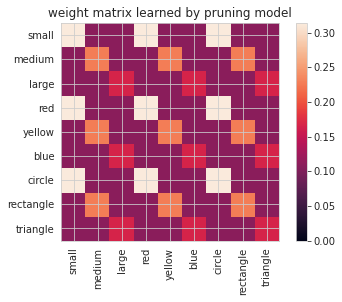

In [26]:
pruning_model_weights=np.ones((9,9))

pruning_factor=.1 #gamma above

for stim in stim_mat:
  for i in range(9):
    for j in range(9):
      if stim[0,i]*stim[0,j]<10**-8:
        pruning_model_weights[i,j]*=1-pruning_factor
plt.imshow(pruning_model_weights,vmin=0,vmax=np.max(pruning_model_weights))
plt.xticks(np.arange(9),FeatureNames,rotation=90)
plt.yticks(np.arange(9),FeatureNames)
plt.colorbar()
plt.title('weight matrix learned by pruning model')

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: UserWarning: In Matplotlib 3.3 individual lines on a stem plot will be added as a LineCollection instead of individual lines. This significantly improves the performance of a stem plot. To remove this warning and switch to the new behaviour, set the "use_line_collection" keyword argument to True.
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: UserWarning: In Matplotlib 3.3 individual lines on a stem plot will be added as a LineCollection instead of individual lines. This significantly improves the performance of a stem plot. To remove this warning and switch to the new behaviour, set the "use_line_collection" keyword argument to True.
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: UserWarning: In Matplotlib 3.3 individual lines on a stem plot will be added as a LineCollection instead of individual lines. This significantly improves the performance of a stem plot. To remove this warni

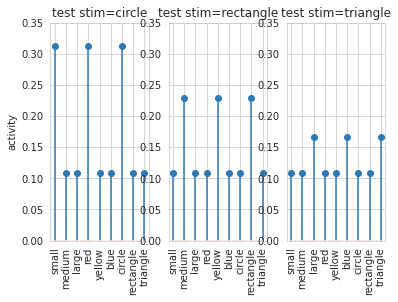

In [27]:
circle=[0,0,0,0,0,0,1,0,0]
rectangle=[0,0,0,0,0,0,0,1,0]
test_stims=[circle,rectangle,triangle]
test_stim_labels=['circle','rectangle','triangle']
for i in range(3):
  plt.subplot(1,3,i+1)
  plt.title('test stim='+test_stim_labels[i])
  plt.stem(np.dot(pruning_model_weights,test_stims[i]))
  plt.xticks(np.arange(9),FeatureNames,rotation=90)
  plt.ylim(0,.35)
  if i==0:
    plt.ylabel('activity')

## **End Solution**

## Exercise 8:  Both Connecting & Pruning

### 8a.  Combined Model
Combine Hebbian Model #2 with your model created above for Homework #2a to create a more sophisticated model that both strengthens connections between neurons that fire together and prunes away connections between neurons that fire independently.  Use stim_mat to train your model.  You will need to find a good balance between the rate of growing (strengthening) connections and the rate of pruning (weakening) connections to ensure that the model learns effectively.  Explain how these rates interact and discuss the growing & pruning rates that appear to optimize learning over the current set of stimuli.      

## **Solution**

We will combine the Hebbian learning rule that we used in Hebbian Model #2 with the Pruning learning rule used above. If some pair of features $x_i,x_j$ occur together, then we will update $w_{ij}$ using Hebb's rule. But if they do not occur together, then we will prune $w_{ij}$ using the Pruning learning rule. 

Mathematically speaking, if $x_ix_j=0$, then the weight update is defined as
$$\Delta w_{ij}=(1-\gamma) w_{ij}$$

But if $x_ix_j>0$, then the weight update is instead
$$\Delta w_{ij}=\alpha x_ix_j$$


If the pruning rate is too large, then the model can "forget" some associations that it has previously learned. However, if the Hebbian learning rate is too large, then weights can grow so large that the pruning dynamics get drowned out. By trying out several values, we found that a pruning rate of .1 and a Hebbian learning rate of .05 appeared to strike a reasonable balance between the two processes.   

Text(0.5, 1.0, 'weight matrix learned by pruning+connecting model')

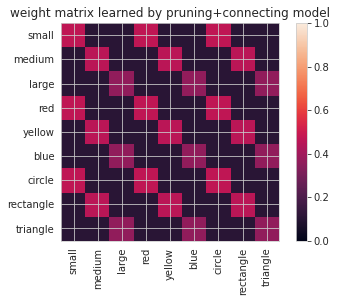

In [28]:
pruning_connecting_model_weights=np.ones((9,9))

pruning_factor=.1
hebbian_lr=.05

for stim in stim_mat:
  for i in range(9):
    for j in range(9):
      if stim[0,i]*stim[0,j]<10**-8:
        pruning_connecting_model_weights[i,j]*=1-pruning_factor
      else:
        pruning_connecting_model_weights[i,j]+=hebbian_lr*stim[0,i]*stim[0,j]
plt.imshow(pruning_connecting_model_weights,vmin=0,vmax=1)
plt.xticks(np.arange(9),FeatureNames,rotation=90)
plt.yticks(np.arange(9),FeatureNames)
plt.colorbar()
plt.title('weight matrix learned by pruning+connecting model')

## **End Solution**

### 8b.  Complex Stimuli
Add 6 new complex stimuli to the learning set.  Each new stimulus should activate exactly 5 feature neurons.  See the example of "small green house" in the cell introducing the stimuli.  Be sensible in how you combine features: medium+small has an obvious interpretation between medium and small, but small+large does not.  Your new set of stimuli will contain the original 3 (src, myr, lbt) plus the 6 new objects you specify.  Train the model you created for #3a above, and then test it to make inferences on partial stimuli (e.g. triangle = [0,0,0,0,0,0,0,0,1]).  Try to optimize the rates of connection growth and pruning to handle this more complex set of stimuli, and explain what you tried and what you learned.  How do you interpret the inferences made when testing this model?     


## **Solution Omitted- very similar to preceding problems**





## Exercise 9:  PsyNeuLink Hebbian Necker Cube
Build a model that uses Hebbian learning in PsyNeuLink to discover the two distinct interpretations of the Necker Cube.  For stimuli, this model will get exposed to one corner of a consistent interpretation of the cube at a time. The cell after the BUILD prompt will help you get started.  It creates a set of 16 stimuli that will be the input to your model.     




In [29]:
Hebb_comp_necker = pnl.Composition()

Hebb_mech_necker=pnl.RecurrentTransferMechanism(
    size=16,
    function=pnl.Linear,
    #integrator_mode = False,
    #integration_rate = .5,
    enable_learning = True,
    learning_rate = .01,
    name='Hebb_mech',
    #matrix=pnl.AutoAssociativeProjection,
    auto=0,
    hetero=0
    )

Hebb_comp_necker.add_node(Hebb_mech_necker)


In [30]:
#Refer to Lab 1 for the full definitions of the vertices
#For now, it is enough to know that the first 8 vertices correspond to one interpretation of the cube
#and the second 8 correspond to the second interpretation

Build_N_Matrix = np.zeros((16,5))
Build_N_Matrix[0,:] = [0, 1, 3, 4, 8]
Build_N_Matrix[1,:] = [1, 0, 2, 5, 9]
Build_N_Matrix[2,:] = [2, 1, 3, 6, 10]
Build_N_Matrix[3,:] = [3, 0, 2, 7, 11]
Build_N_Matrix[4,:] = [4, 5, 7, 0, 12]
Build_N_Matrix[5,:] = [5, 4, 6, 1, 13]
Build_N_Matrix[6,:] = [6, 5, 7, 2, 14]
Build_N_Matrix[7,:] = [7, 4, 6, 3, 15]
Build_N_Matrix[8,:] = [8, 9, 11, 12, 0]
Build_N_Matrix[9,:] = [9, 8, 10, 13, 1]
Build_N_Matrix[10,:] = [10, 9, 11, 14, 2]
Build_N_Matrix[11,:] = [11, 8, 10, 15, 3]
Build_N_Matrix[12,:] = [12, 13, 15, 8, 4]
Build_N_Matrix[13,:] = [13, 12, 14, 9, 5]
Build_N_Matrix[14,:] = [14, 13, 15, 10, 6]
Build_N_Matrix[15,:] = [15, 12, 14, 11, 7]

Build_N_Matrix = Build_N_Matrix.astype(int)

Necker_Matrix = np.zeros((16,16))
Necker_Matrix = Necker_Matrix.astype(int)

excite = 1

for x in range(0,16):
    Necker_Matrix[Build_N_Matrix[x,0], Build_N_Matrix[x,0]] = excite
    Necker_Matrix[Build_N_Matrix[x,0], Build_N_Matrix[x,1]] = excite
    Necker_Matrix[Build_N_Matrix[x,0], Build_N_Matrix[x,2]] = excite
    Necker_Matrix[Build_N_Matrix[x,0], Build_N_Matrix[x,3]] = excite

# The following line of code should be run after you initialize and name your RecurrentTransferMechanism.  
# It breaks the Necker_Matrix defined above into 16 arrays that will be a dictionary of inputs. 
# You need to replace "Hebb" below with the name of your RecurrentTransferMechanism that receives input.  

input_dictNC = {Hebb_mech_necker:np.split(Necker_Matrix[np.random.permutation(16)],16)}
out=Hebb_comp_necker.learn(num_trials=16,
    inputs=input_dictNC)


/usr/local/lib/python3.7/dist-packages/psyneulink/core/compositions/composition.py:7479: UserWarning: Hebb_mech-4 has been specified to project to Hebb_mech-4 recurrent projection, but Hebb_mech-4 recurrent projection is not in Composition-4 or any of its nested Compositions. This projection will be deactivated until Hebb_mech-4 recurrent projection is added to Composition-4 or a composition nested within it.
  f"{node.name} has been specified to project to {receiver.name}, "


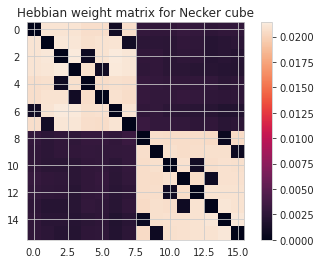

In [31]:

plt.imshow(Hebb_mech_necker.matrix.base)
plt.title('Hebbian weight matrix for Necker cube')
plt.colorbar()

In [32]:
#we now show that the model can settle on either of the interpretations when presented with a partial perception

#this input corresponds to perceiving only the Front Upper Left corner in the first interpretation of the cube 
FUL_interp1=[1]+[0]*15
#this input corresponds to perceiving only the Front Upper Left corner in the second interpretation of the cube 
FUL_interp2=[0]*12+[1]+[0]*3

#run the model on each input to determine the 
completion1=Hebb_mech_necker.matrix.base@FUL_interp1
completion2=Hebb_mech_necker.matrix.base@FUL_interp2

Text(0.5, 1.0, 'Pattern completion in Hebbian Necker cube model')

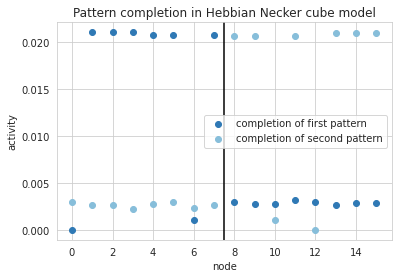

In [33]:
#plot the completion of each input
#nodes to the left of the black vertical line correspond to the first interpretation of the cube
#and those to the right to the second interpretation
plt.axvline(7.5,c='black')
plt.scatter(np.arange(16),completion1,label='completion of first pattern')
plt.scatter(np.arange(16),completion2,label='completion of second pattern')
plt.ylabel('activity')
plt.xlabel('node')
plt.legend()
plt.title('Pattern completion in Hebbian Necker cube model')